# GP demo

This notebook demonstrates the use of GPyTorch and the input warping kernel on a sample dataset

In [2]:
import os
import csv
import sys
import torch
import pickle
import gpytorch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F
from gpytorch.kernels import RBFKernel, ScaleKernel, AdditiveKernel

In [5]:
# we need to manually add the project directory to the path when using Jupyter notebooks
sys.path.append("/home/santeri/repos/HIT_VAE")

In [6]:
from hit_vae.models import mnist_conv_vae
from hit_vae.models import losses
from hit_vae.utils import data_loading
from hit_vae.utils import plotting
from hit_vae.basic_kernels.constant_kernel import ConstantKernel
from hit_vae.basic_kernels.categorical_kernel import CategoricalKernel
from hit_vae.basic_kernels.input_warping_kernel import InputWarpKernel

In [7]:
plt.style.use('ggplot')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('using device: {}'.format(device))

using device: cuda


## Loading the data

In [9]:
train_Z, train_labels = pickle.load(open( "../../data/demo_Z/training_Z.p", "rb" ))

FileNotFoundError: [Errno 2] No such file or directory: '../../data/demo_Z/training_Z.p'

In [7]:
label_df = pd.DataFrame(train_labels)

label_df.head()

,subject,digit,angle,sick,timestamp
0,17,3,5.356508,0,4
1,15,3,-0.977179,0,-1
2,19,3,5.289869,0,-5
3,11,3,1.002485,0,-7
4,27,3,37.660787,1,2


In [8]:
label_df = pd.DataFrame(train_labels)

label_df.head()

train_x = torch.Tensor(label_df.values).to(device)
#train_x = torch.cat((timestamps, subjects, sick), 1)
train_y = train_Z.view(-1)

In [9]:
test_Z, test_labels = pickle.load(open( "../../data/demo_Z/test_Z.p", "rb" ))

In [1]:
test_label_df = pd.DataFrame(test_labels)

test_label_df.head()

NameError: name 'pd' is not defined

In [11]:
test_x = torch.Tensor(test_label_df.values).to(device)
#train_x = torch.cat((timestamps, subjects, sick), 1)
test_y = test_Z.view(-1)

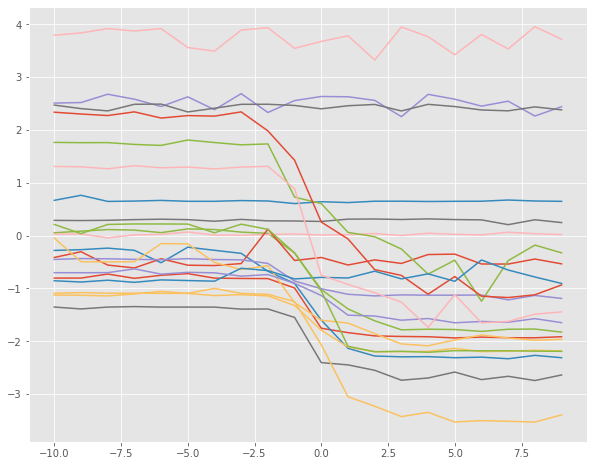

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

plotting.categorical_plot(train_x.cpu().numpy()[:, 4], train_y.cpu().numpy(), train_x.cpu().numpy()[:, 0], ax)

## Configuring the model

In [13]:
def time_warp(x):
    omega = (-0.5 + 1 / (1 + torch.exp(-x)))
    return omega

def input_warping(x, c, a, b):
    omega = 2 * c * (-0.5 + 1 / (1 + torch.exp(-a * (x - b))))
    return omega

In [15]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
const_module = ScaleKernel(ConstantKernel(active_dims=4)) * CategoricalKernel(active_dims=3)
rbf_module = ScaleKernel(RBFKernel(active_dims=4)) * CategoricalKernel(active_dims=3)

iw_module = ScaleKernel(InputWarpingKernel(active_dims=4)) * CategoricalKernel(active_dims=3)

sum_covar_module = const_module + rbf_module

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

#gpmodel = ExactGPModel(train_x, train_y, likelihood, const_covar_module).to(device)
#gpmodel = ExactGPModel(train_x, train_y, likelihood, sum_covar_module).to(device)
gpmodel = ExactGPModel(train_x, train_y, likelihood, sum_covar_module).to(device)

In [17]:
for param_name, param in gpmodel.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.kernels.0.kernels.0.raw_outputscale value = 0.0
Parameter name: covar_module.kernels.1.kernels.0.raw_outputscale value = 0.0
Parameter name: covar_module.kernels.1.kernels.0.base_kernel.raw_lengthscale value = 0.0


In [18]:
# Find optimal model hyperparameters
gpmodel.train()
likelihood.train()

loss = torch.tensor([], requires_grad=True)

optimizer = torch.optim.Adam([ {'params': gpmodel.parameters()},], lr=0.01)

# Use the adam optimizer
#optimizer = torch.optim.Adam([
#    {'params': gpmodel.likelihood.parameters()},  # Includes GaussianLikelihood parameters
#    {'params': gpmodel.mean_module.parameters()},  # Includes GaussianLikelihood parameters
#    {'params': gpmodel.covar_module.parameters(), 'weight_decay': 0.00001}
#], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpmodel)

training_iter = 20
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gpmodel(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.mean().backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        #gpmodel.covar_module.base_kernel.lengthscale.item(),
        gpmodel.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/20 - Loss: 1.734  noise: 0.693
Iter 2/20 - Loss: 1.733  noise: 0.698
Iter 3/20 - Loss: 1.731  noise: 0.703
Iter 4/20 - Loss: 1.727  noise: 0.708
Iter 5/20 - Loss: 1.729  noise: 0.713
Iter 6/20 - Loss: 1.726  noise: 0.718
Iter 7/20 - Loss: 1.722  noise: 0.723
Iter 8/20 - Loss: 1.722  noise: 0.728
Iter 9/20 - Loss: 1.720  noise: 0.733
Iter 10/20 - Loss: 1.719  noise: 0.738
Iter 11/20 - Loss: 1.719  noise: 0.743
Iter 12/20 - Loss: 1.715  noise: 0.747
Iter 13/20 - Loss: 1.712  noise: 0.752
Iter 14/20 - Loss: 1.713  noise: 0.756
Iter 15/20 - Loss: 1.710  noise: 0.760
Iter 16/20 - Loss: 1.710  noise: 0.765
Iter 17/20 - Loss: 1.705  noise: 0.769
Iter 18/20 - Loss: 1.704  noise: 0.773
Iter 19/20 - Loss: 1.708  noise: 0.776
Iter 20/20 - Loss: 1.703  noise: 0.779


In [19]:
for param_name, param in gpmodel.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.1708465963602066
Parameter name: mean_module.constant                       value = 0.11028921604156494
Parameter name: covar_module.kernels.0.kernels.0.raw_outputscale value = 0.14750342071056366
Parameter name: covar_module.kernels.1.kernels.0.raw_outputscale value = 0.19136808812618256
Parameter name: covar_module.kernels.1.kernels.0.base_kernel.raw_lengthscale value = 0.20152629911899567


In [20]:
# Get into evaluation (predictive posterior) mode
gpmodel.eval()
likelihood.eval()

with torch.no_grad():
    
    #print(test_timestamps.shape)
    #print(test_subjects.shape)
    
    #observed_pred = likelihood(gpmodel(train_x))
    observed_pred = likelihood(gpmodel(test_x))
    
    print(observed_pred)

MultivariateNormal(loc: torch.Size([180]))


In [21]:
observed_pred.log_prob(test_y).detach().cpu()

tensor(-254.2873)

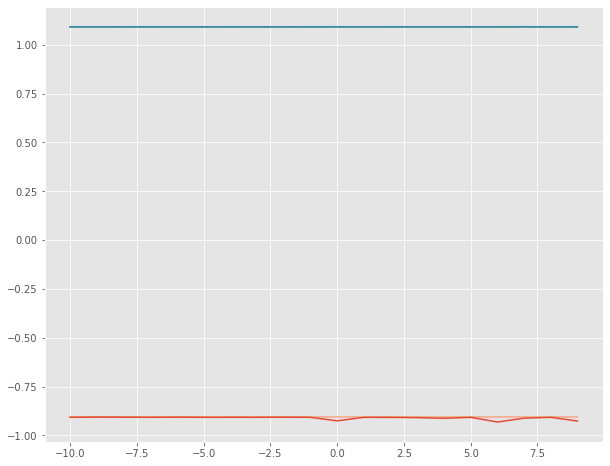

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

#axes[0].plot(train_x[:, 4].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'ob')

plotting.categorical_plot(test_x[:, 4], observed_pred.mean, test_x[:, 0], ax, tensors=True, 
                       savepath='../../results/LonGP/MNIST_test_set_sum_covar.png')

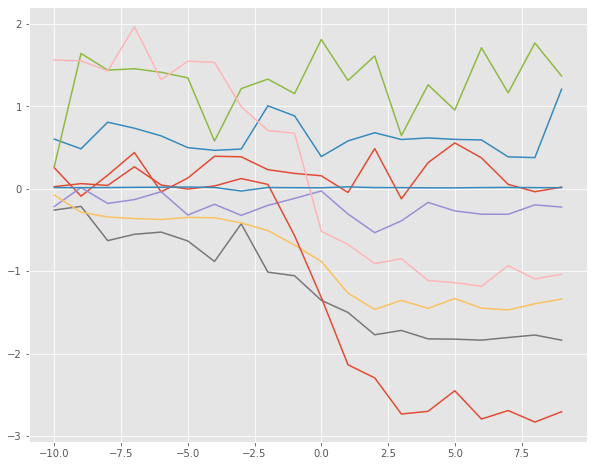

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

plotting.categorical_plot(test_x.cpu().numpy()[:, 4], test_y.cpu().numpy(), test_x.cpu().numpy()[:, 0], ax,
                       savepath='../../results/LonGP/MNIST_test_set_true.png')

In [24]:
#print(test_x.shape)

# Get into evaluation (predictive posterior) mode
gpmodel.eval()
likelihood.eval()

with torch.no_grad():
    
    #print(test_timestamps.shape)
    #print(test_subjects.shape)
    output = gpmodel(train_x)
    
    #print(output.shape)
    
    observed_pred_train = likelihood(output)
    
    print(observed_pred_train)

MultivariateNormal(loc: torch.Size([420]))


/u/14/mentus1/unix/.conda/envs/gppvae/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:247: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


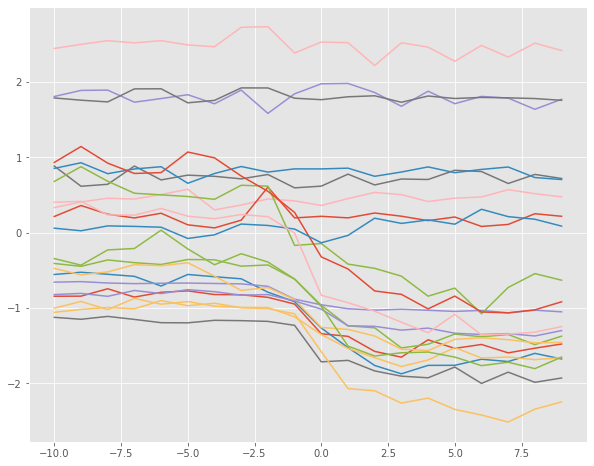

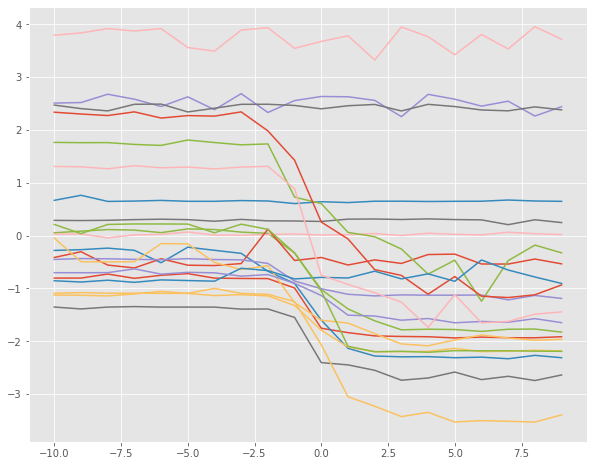

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

#axes[0].plot(train_x[:, 4].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'ob')

plotting.categorical_plot(train_x[:, 4], observed_pred_train.mean, train_x[:, 0], ax, tensors=True)

fig, ax = plt.subplots(figsize=(10, 8))

plotting.categorical_plot(train_x.cpu().numpy()[:, 4], train_y.cpu().numpy(), train_x.cpu().numpy()[:, 0], ax)